In [ ]:
import numpy as np
def bs_price(S0, v0, r, T, N, M):
    """
    Simulate Black-Scholes price paths with constant volatility.
    """
    # Calculate dt from T and N
    dt = T/N

    # Pre-allocate arrays
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)


    # Generate random numbers
    mu = np.zeros(1)  # Mean vector for bivariate normal
    cov = np.eye(1)   # Covariance matrix (uncorrelated in BS case)
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    # Precompute constants for efficiency
    drift = (r - 0.5*v0)*dt
    diffusion = np.sqrt(v0 * dt)

    # Vectorized simulation of price paths
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp(drift + diffusion * Z[i-1,:,0])
        v[i] = v[i-1]  # Variance remains constant

    return S, v

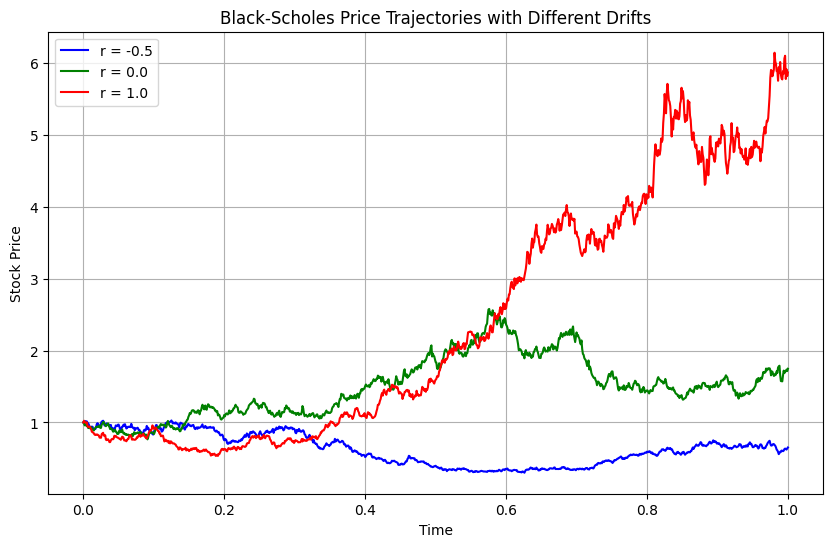

In [ ]:
import matplotlib.pyplot as plt

# Set parameters
S0 = 1.0  # Initial stock price
v0 = 0.5  # Initial volatility
r_values = [-0.5, 0.0, 1.0]  # Different drift rates
T = 1.0   # Time horizon
N = 1000  # Number of time steps
M = 1     # Number of paths (one trajectory per drift)

# Create time points for plotting
t = np.linspace(0, T, N+1)

# Create the plot
plt.figure(figsize=(10, 6))

# Simulate and plot trajectory for each drift rate
colors = ['b', 'g', 'r']
for r, color in zip(r_values, colors):
    S, v = bs_price(S0, v0, r, T, N, M)
    plt.plot(t, S[:,0], f'{color}-', label=f'r = {r}')

plt.title('Black-Scholes Price Trajectories with Different Drifts')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class BSTrajectoryDataset(Dataset):
    def __init__(self, num_samples=100, N=1000, T=1.0, S0=1.0, rmin=-2.0, rmax=2.0, vmin=0.01, vmax=0.5):
        self.num_samples = num_samples

        # Generate random drift values uniformly between rmin and rmax
        self.r_values = torch.FloatTensor(num_samples).uniform_(rmin, rmax)

        # Generate random volatility values uniformly between vmin and vmax
        self.v_values = torch.FloatTensor(num_samples).uniform_(vmin, vmax)

        # Initialize arrays to store trajectories and parameters
        self.trajectories = torch.zeros((num_samples, N+1))
        # Store both r and v values as parameters
        self.parameters = torch.stack([self.r_values, self.v_values], dim=1)

        # Generate trajectories for each r and v value pair
        dt = T/N
        t = torch.linspace(0, T, N+1)

        for i in range(num_samples):
            r = self.r_values[i].item()
            v = self.v_values[i].item()
            S, _ = bs_price(S0, v, r, T, N, M=1)
            self.trajectories[i] = torch.from_numpy(S[:,0])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return {
            'trajectory': self.trajectories[idx],
            'parameter': self.parameters[idx]
        }

# Create dataset
bs_dataset = BSTrajectoryDataset(num_samples=10000, N=40)

# Example of accessing a single item
sample = bs_dataset[0]
print(f"Sample trajectory shape: {sample['trajectory'].shape}")
print(f"Sample parameter (r value): {sample['parameter']}")

# Create DataLoader
batch_size = 512
bs_dataloader = DataLoader(bs_dataset, batch_size=batch_size, shuffle=True)

# Example of iterating through the dataloader
for batch in bs_dataloader:
    trajectories = batch['trajectory']  # Shape: [batch_size, N+1]
    parameters = batch['parameter']     # Shape: [batch_size]
    print(f"Batch trajectories shape: {trajectories.shape}")
    print(f"Batch parameters shape: {parameters.shape}")
    break  # Just print first batch as example


Sample trajectory shape: torch.Size([41])
Sample parameter (r value): tensor([0.7500, 0.3708])
Batch trajectories shape: torch.Size([512, 41])
Batch parameters shape: torch.Size([512, 2])


In [ ]:
import torch.nn as nn
# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, seq_length, num_params=2):
        super(MLPModel, self).__init__()

        # Input size is sequence_length + parameter + time = T + 1 + 1
        input_size = seq_length + num_params + 1

        # Define layers with reasonable sizes
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_params)
        )

    def forward(self, trajectory, parameters, times):
        # trajectory shape: [B x T]
        # parameters shape: [B x 1]
        # times shape: [B x 1]

        # Concatenate all inputs along dimension 1
        x = torch.cat([trajectory, parameters, times], dim=1)

        # Pass through MLP layers
        output = self.layers(x)

        return output


In [ ]:
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import get_cosine_schedule_with_warmup



# Create model and optimizer
seq_length = 40+1  # Match the sequence length from dataset
model = MLPModel(seq_length)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def compute_loss(model, trajectories, true_params, noised_params, t):
    """
    Compute flow matching loss for a batch
    """
    # Get model prediction
    pred_params = model(trajectories, noised_params, t)

    # Compute MSE loss
    loss = nn.MSELoss()(pred_params, true_params)
    return loss

# Lists to store metrics
losses = []
learning_rates = []

num_warmups = 1000
num_epochs = 30000
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmups,
    num_training_steps=num_epochs
)

# Training loop
progress_bar = tqdm(range(num_epochs), desc='Training')
for epoch in progress_bar:
    epoch_loss = 0.0
    n_batches = 0

    for batch in bs_dataloader:
        # Sample random time between 0 and 1
        t = torch.rand(batch['trajectory'].shape[0], 1)

        # Process parameters
        true_params = batch['parameter']  # [B x num_params]
        noise = torch.randn_like(true_params)*40
        noised_params = true_params * (1-t) + noise * t

        # Zero gradients
        optimizer.zero_grad()

        # Compute loss
        loss = compute_loss(model, batch['trajectory'], true_params, noised_params, t)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    # Step the scheduler
    scheduler.step()

    # Calculate and store metrics
    avg_loss = epoch_loss / n_batches
    current_lr = scheduler.get_last_lr()[0]
    losses.append(avg_loss)
    learning_rates.append(current_lr)

    # Update progress bar
    progress_bar.set_postfix({
        'loss': f'{avg_loss:.4f}',
        'lr': f'{current_lr:.6f}'
    })

    # Plot training progress every 100 epochs
    #if (epoch + 1) % 100 == 0:
    #    plt.figure(figsize=(10, 4))
    #
    #    plt.subplot(1, 2, 1)
    #    plt.plot(losses)
    #    plt.title('Training Loss')
    #    plt.xlabel('Epoch')
    #    plt.ylabel('Loss')
    #
    #    plt.subplot(1, 2, 2)
    #    plt.plot(learning_rates)
    #    plt.title('Learning Rate')
    #    plt.xlabel('Epoch')
    #    plt.ylabel('LR')
    #
    #    plt.tight_layout()
    #    plt.show()


Training:  44%|████▍     | 13239/30000 [29:59<34:36,  8.07it/s, loss=0.0107, lr=0.000621]

In [ ]:
tp = true_params[0:1]
tval = torch.ones((1, 1))*0.9
nois_p = tp*tval + (1-tval)*torch.randn_like(tp)
traj = batch['trajectory'][0:1]
print(traj)
print(traj.shape)
model(traj, nois_p, tval), tp

tensor([[1.0000, 1.0213, 0.9740, 1.0539, 1.1074, 1.1501, 1.2218, 1.2223, 1.2419,
         1.3324, 1.4893, 1.4460, 1.4497, 1.4451, 1.4278, 1.5249, 1.5453, 1.5760,
         1.5339, 1.5491, 1.7144, 1.9035, 2.0303, 2.2376, 2.3380, 2.5613, 2.6983,
         2.9318, 3.2758, 3.6612, 3.7456, 4.0600, 4.5130, 4.9882, 5.7280, 5.6458,
         5.6913, 6.1320, 6.0153, 5.8752, 5.8464]])
torch.Size([1, 41])


(tensor([[1.9268, 0.3105]], grad_fn=<AddmmBackward0>),
 tensor([[1.9560, 0.1586]]))

In [ ]:
def infer_parameter(model, trajectory, num_params, num_samples=1, n_steps=100, Tf = 0.9):
    """
    Infer parameter using Euler time-stepping scheme.

    Args:
        model: trained neural network model
        trajectory: input trajectory tensor [1 x seq_len x features]
        n_steps: number of Euler steps (default 100)

    Returns:
        final parameter estimate
    """
    # Initialize parameter from normal distribution
    p = torch.randn(num_samples, num_params)*40

    # Time step size
    h = Tf / n_steps

    # Current time
    that = torch.zeros(num_samples, 1)

    # Euler steps
    for i in range(n_steps):
        # Get model prediction
        t = 1 - torch.exp(-that)
        p_next = (1-h) * p + h * model(trajectory.repeat(num_samples, 1), p, t)
        # Update parameter
        p = p_next

        # Update time
        that = that + h
    return p, 1-torch.exp(-that)


In [ ]:
num_samples = 100
k = 3
traj = batch['trajectory'][k:k+1]
tp = batch['parameter'][k:k+1]
print(tp)
p_pred, t = infer_parameter(model, traj, num_params=2, num_samples=num_samples, n_steps=100, Tf = 2.5)

preds = model(traj.repeat(num_samples, 1), p_pred, t)

print("Model Predictions:")
print(f"Mean predictions: [{preds.mean(dim=0)[0]:.4f}, {preds.mean(dim=0)[1]:.4f}]")
print(f"Standard deviations: [{p_pred.std(dim=0)[0]:.4f}, {p_pred.std(dim=0)[1]:.4f}]")
print(f"True parameters: [{tp[0,0]:.4f}, {tp[0,1]:.4f}]")
#print(f"Mean inferred parameters: [{p_pred.mean(dim=0)[0]:.4f}, {p_pred.mean(dim=0)[1]:.4f}]")
#plt.figure(figsize=(10,6))
#plt.hist(preds.detach().numpy(), bins=30, density=True, alpha=0.7)
#plt.axvline(x=tp.item(), color='r', linestyle='--', label='True Parameter')
#plt.xlabel('Parameter Value')
#plt.ylabel('Density')
#plt.title('Distribution of Parameter Predictions')
#plt.legend()
#plt.show()



tensor([[-0.8989,  0.4938]])
Model Predictions:
Mean predictions: [-0.9857, 0.3230]
Standard deviations: [3.2916, 3.0125]
True parameters: [-0.8989, 0.4938]


In [ ]:
#print(f"Mean inferred parameters: [{p_pred.mean(dim=0)[0]:.4f}, {p_pred.mean(dim=0)[1]:.4f}]")
#plt.figure(figsize=(10,6))
#plt.hist(preds.detach().numpy(), bins=30, density=True, alpha=0.7)
#plt.axvline(x=tp.item(), color='r', linestyle='--', label='True Parameter')
#plt.xlabel('Parameter Value')
#plt.ylabel('Density')
#plt.title('Distribution of Parameter Predictions')
#plt.legend()
#plt.show()

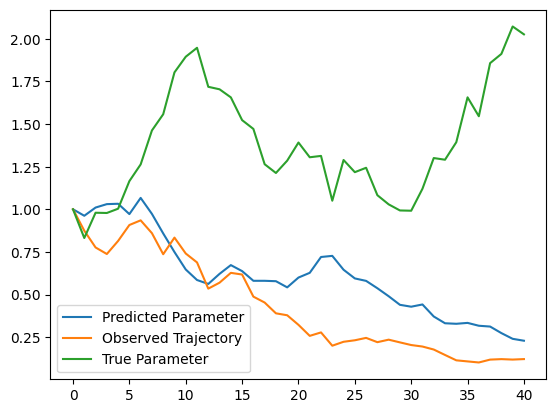

In [ ]:
preds_mean = p_pred.mean(dim=0).detach().numpy()
S, v = bs_price(S0, preds_mean[1], preds_mean[0], T, 40, M=1)
S1, v = bs_price(S0, tp.numpy()[0,1], tp.numpy()[0,0], T, 40, M=1)

plt.plot(S, label='Predicted Parameter')
plt.plot(traj.numpy()[0], label='Observed Trajectory')
plt.plot(S1, label='True Parameter')
plt.legend()



In [ ]:
preds_mean, tp

(array([-0.8660734 ,  0.23398179], dtype=float32),
 tensor([[-0.8989,  0.4938]]))

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
apple_data = yf.download('AAPL', start='2022-11-02', end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
tmp_data = apple_data['Close']
new_list = tmp_data.values.reshape(1,-1)
min_value = min(new_list[0])
max_value = max(new_list[0])
normalized_data = [(x - min_value) / (max_value - min_value) for x in new_list[0]]
#normalized_data[0] = 1.0
#normalized_data[-3] = normalized_data[-4]

print(normalized_data)

[0.7425679935880309, 0.49940597687111177, 0.4887126445555513, 0.5100986985229571, 0.5330700354948285, 0.34970176710812567, 0.8249501927407351, 0.9370301896874165, 0.8807917255066601, 0.950494713942216, 0.900990038548147, 0.9774274264341055, 1.0, 0.8700996145185298, 0.9560389298118392, 0.9912882714400214, 0.8740591580474028, 0.7199996946681424, 0.5992079691614823, 0.8708910346933323, 0.881979466432579, 0.8621786954696385, 0.8154458226785237, 0.6681189267585207, 0.5900999198503873, 0.6578231365215068, 0.6384168543185375, 0.730693637647418, 0.7695055913896416, 0.68, 0.4142574710888897, 0.33544582267852374, 0.25069363764741803, 0.24792183504446394, 0.37267249341628184, 0.24514881111407963, 0.2304941032785008, 0.15801992290370598, 0.0, 0.1413854433036907, 0.15405915804740278]


In [ ]:
tmp_data_tensor = torch.tensor(normalized_data, dtype=torch.float32).reshape(1,-1)
traj = tmp_data_tensor
traj.shape
print(traj)
print(traj.shape)

tensor([[0.7426, 0.4994, 0.4887, 0.5101, 0.5331, 0.3497, 0.8250, 0.9370, 0.8808,
         0.9505, 0.9010, 0.9774, 1.0000, 0.8701, 0.9560, 0.9913, 0.8741, 0.7200,
         0.5992, 0.8709, 0.8820, 0.8622, 0.8154, 0.6681, 0.5901, 0.6578, 0.6384,
         0.7307, 0.7695, 0.6800, 0.4143, 0.3354, 0.2507, 0.2479, 0.3727, 0.2451,
         0.2305, 0.1580, 0.0000, 0.1414, 0.1541]])
torch.Size([1, 41])


In [ ]:
num_samples = 100
k = 3
traj = traj
tp = batch['parameter'][k:k+1]
print(tp)
p_pred, t = infer_parameter(model, traj, num_params=2, num_samples=num_samples, n_steps=100, Tf = 2.5)

preds = model(traj.repeat(num_samples, 1), p_pred, t)

print("Model Predictions:")
print(f"Mean predictions: [{preds.mean(dim=0)[0]:.4f}, {preds.mean(dim=0)[1]:.4f}]")
print(f"Standard deviations: [{p_pred.std(dim=0)[0]:.4f}, {p_pred.std(dim=0)[1]:.4f}]")
print(f"True parameters: [{tp[0,0]:.4f}, {tp[0,1]:.4f}]")
#print(f"Mean inferred parameters: [{p_pred.mean(dim=0)[0]:.4f}, {p_pred.mean(dim=0)[1]:.4f}]")
#plt.figure(figsize=(10,6))
#plt.hist(preds.detach().numpy(), bins=30, density=True, alpha=0.7)
#plt.axvline(x=tp.item(), color='r', linestyle='--', label='True Parameter')
#plt.xlabel('Parameter Value')
#plt.ylabel('Density')
#plt.title('Distribution of Parameter Predictions')
#plt.legend()
#plt.show()



tensor([[-0.8989,  0.4938]])
Model Predictions:
Mean predictions: [0.1832, 0.5078]
Standard deviations: [3.4496, 3.1613]
True parameters: [-0.8989, 0.4938]


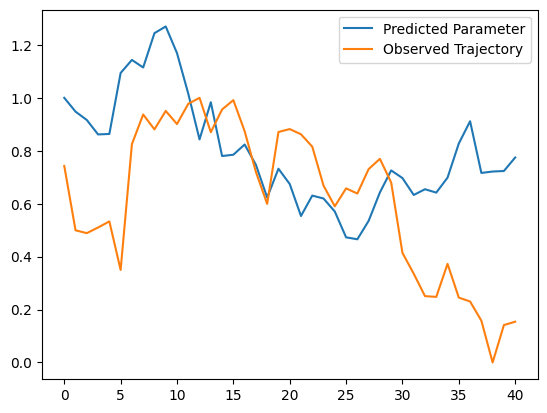

In [ ]:
preds_mean = p_pred.mean(dim=0).detach().numpy()
S, v = bs_price(S0, preds_mean[1], preds_mean[0], T, 40, M=1)
#S1, v = bs_price(S0, tp.numpy()[0,1], tp.numpy()[0,0], T, 40, M=1)
plt.plot(S, label='Predicted Parameter')
plt.plot(traj.numpy()[0], label='Observed Trajectory')
plt.legend()



In [ ]:
tp = true_params[0:1]
tval = torch.ones((1, 1))*0.9
nois_p = tp*tval + (1-tval)*torch.randn_like(tp)
print(traj)
print(traj.shape)
model(traj, nois_p, tval)

tensor([[0.7426, 0.4994, 0.4887, 0.5101, 0.5331, 0.3497, 0.8250, 0.9370, 0.8808,
         0.9505, 0.9010, 0.9774, 1.0000, 0.8701, 0.9560, 0.9913, 0.8741, 0.7200,
         0.5992, 0.8709, 0.8820, 0.8622, 0.8154, 0.6681, 0.5901, 0.6578, 0.6384,
         0.7307, 0.7695, 0.6800, 0.4143, 0.3354, 0.2507, 0.2479, 0.3727, 0.2451,
         0.2305, 0.1580, 0.0000, 0.1414, 0.1541]])
torch.Size([1, 41])


tensor([[0.1833, 0.5078]], grad_fn=<AddmmBackward0>)